In [1]:
%load_ext autoreload
%autoreload 2

import os
import zarr
import dask.array as da
import napari
import sys
import numpy as np


from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

sys.path.append('..')
from tracks_interactions.db.db_model import Base, CellDB, TrackDB
import tracks_interactions.graph.family_graph as fg
#from tracks_interactions.widget.event_handler import EventHandler

In [2]:
os.environ['NAPARI_PERFMON'] = '0'

In [3]:
from tifffile import imread
labels = imread(r'D:\kasia\tracking\E6_exp\sample_data\track_labels.tif')

In [4]:
# get images
ch1 = imread(r'D:\kasia\tracking\E6_exp\sample_data\ch1.tif')
ch2 = imread(r'D:\kasia\tracking\E6_exp\sample_data\ch2.tif')

In [5]:
# checkout labels as editable array
labels = np.array(labels).astype('int32')

In [6]:
# display channels and labels
viewer = napari.Viewer()
viewer.add_image(ch1, name='ch1', colormap = 'green',blending='additive')
viewer.add_image(ch2, name='ch2', colormap = 'red',blending='additive')
labels_layer = viewer.add_labels(labels,name='Labels')

In [7]:
# get access to the database
new_db_path =r'D:\kasia\tracking\E6_exp\sample_data\sample_db_2tables.db'
engine = create_engine(f'sqlite:///{new_db_path}')
session = sessionmaker(bind=engine)()

### Family graph display

In [8]:
from tracks_interactions.graph.family_graph import FamilyGraphWidget
plot_widget = FamilyGraphWidget(viewer,session)
viewer.window.add_dock_widget(plot_widget,area='bottom')

### Navigation widget

In [9]:
from tracks_interactions.widget.track_navigation_widget import TrackNavigationWidget
track_navigation_widget = TrackNavigationWidget(viewer,session)
viewer.window.add_dock_widget(track_navigation_widget,area='right',name='Track Navigation')

### Modification widget

In [10]:
from tracks_interactions.widget.track_modification_widget import TrackModificationWidget
track_modification_widget = TrackModificationWidget(viewer,session)
viewer.window.add_dock_widget(track_modification_widget,area='right',name='Track Modifications')

### Signal graph

In [11]:
from tracks_interactions.graph.signal_graph import SignalGraphWidget
signal_widget = SignalGraphWidget(viewer,session)
viewer.window.add_dock_widget(signal_widget,area='right')

### Cell modification

In [22]:
from tracks_interactions.widget.cell_modification_widget import CellModificationWidget
cell_modification_widget = CellModificationWidget(viewer,session)
viewer.window.add_dock_widget(cell_modification_widget,area='right',name='Save Cell')

### Tests

In [31]:
query = (session.query(CellDB.t, CellDB.signals["ch1_nuc"])
    .filter(CellDB.track_id == 52)
    .order_by(CellDB.t)
    .all())

In [33]:
cell = (session.query(CellDB)
    .filter(CellDB.track_id == 52)
    .first())


In [57]:
from skimage.transform import resize
ring_width = 5
ch_names = None
ch_list = [ch1, ch2]

# caclulate cell area
mask = np.array(cell.mask)
area = mask.sum()

cell_dict = {"area": int(area)}

# create a ring mask
cyto_mask = resize(
    mask,
    np.array(mask.shape) + 2 * ring_width,
    order=0,
    anti_aliasing=False,
)
cell_in_cyto_mask = np.zeros_like(cyto_mask)
cell_in_cyto_mask[
    ring_width:-ring_width, ring_width:-ring_width
] = cell.mask
cyto_mask[cell_in_cyto_mask] = 0

# check how to cut boxes

# calculate positions
r_start = cell.bbox_0 - ring_width
c_start = cell.bbox_1 - ring_width
r_paste_start = c_paste_start = 0

# account for edge cases
if r_start < 0:
    r_paste_start = -r_start
    r_start  = 0
if c_start < 0:
    c_paste_start = -c_start
    c_start  = 0

ch = ch_list[0]
if ch.ndim == 3:
    r_end = np.min([ch.shape[1], cell.bbox_2 + ring_width])
    c_end = np.min([ch.shape[2], cell.bbox_3 + ring_width])
else:
    r_end = np.min([ch.shape[0], cell.bbox_2 + ring_width])
    c_end = np.min([ch.shape[1], cell.bbox_3 + ring_width])

# get signals for all the channels
if ch_names is None:
    ch_names = [f"ch{i}" for i in range(len(ch_list))]

for ch, ch_name in zip(ch_list, ch_names):
    
    # create a box for the channel
    ch_box = np.zeros_like(cyto_mask).astype(ch.dtype)

    # get channel ring boxes
    if ch.ndim == 3:
        signal = ch[cell.t, r_start:r_end, c_start:c_end]
    else:
        signal = ch[r_start:r_end, c_start:c_end]

    # paste the signal into the box
    ch_box[r_paste_start:(r_paste_start+signal.shape[0]),c_paste_start:(c_paste_start+signal.shape[1])] = signal

    # calculate signals
    ch_nuc = np.mean(ch_box[cell_in_cyto_mask])
    ch_cyto = np.mean(ch_box[cyto_mask])

    # compute if necessary
    if type(ch_nuc) == da.core.Array:
        ch_nuc = ch_nuc.compute()
        ch_cyto = ch_cyto.compute()

    # add to the dictionary
    cell_dict[ch_name + "_nuc"] = ch_nuc
    cell_dict[ch_name + "_cyto"] = ch_cyto


In [58]:
print(signal.shape)
print(ch_box.shape)
print(r_paste_start, r_paste_start+signal.shape[0], c_paste_start, c_paste_start+signal.shape[1])

(87, 78)
(87, 78)
0 87 0 78


In [59]:
type(ch_box)

numpy.ndarray

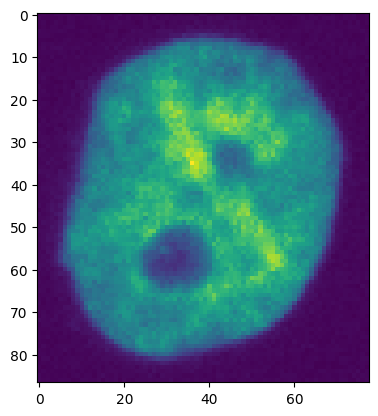

In [60]:
import matplotlib.pyplot as plt
plt.imshow(ch_box)

In [10]:
from numba import jit
from skimage.measure import regionprops, regionprops_table
import pandas as pd

In [21]:
%time
frame = 90
label_of_interest = 40
coords = np.argwhere(labels[frame] == label_of_interest)
ymin, xmin = coords.min(axis=0)
ymax, xmax = coords.max(axis=0)

SyntaxError: invalid syntax (2113402391.py, line 5)

In [19]:
# get coordinates of visible part
coord_view = viewer.layers['Labels'].corner_pixels.T
r_start = coord_view[1,0]
r_end = coord_view[1,1]
c_start = coord_view[2,0]
c_end = coord_view[2,1]

labels_cropped = labels[frame, r_start:r_end, c_start:c_end]==label_of_interest

In [20]:
labels_cropped.shape

(403, 315)

In [15]:
t = viewer.layers['Labels'].data
sel = t[tuple(slice(i[0], i[1]) for i in layer.corner_pixels.T)]

NameError: name 'layer' is not defined

In [20]:
%time
data = regionprops_table([labels[9]==40],properties=['label','centroid','area','bbox'])

CPU times: total: 0 ns
Wall time: 0 ns


AttributeError: 'list' object has no attribute 'ndim'

In [10]:
tr = session.query(TrackDB).filter_by(track_id=12539).first()
print(tr.t_begin,tr.t_end,tr.parent_track_id,tr.root)

AttributeError: 'NoneType' object has no attribute 't_begin'

In [16]:
from sqlalchemy import and_
from tracks_interactions.db.db_model import CellDB
import matplotlib.pyplot as plt

In [23]:
curr_tr = 14711
curr_fr = 130
c = session.query(CellDB).filter(and_(CellDB.track_id == curr_tr, CellDB.t == curr_fr)).first()
    

In [19]:
%time
c = session.query(CellDB).filter(and_(CellDB.track_id == curr_tr, CellDB.t == curr_fr)).first()

CPU times: total: 0 ns
Wall time: 0 ns


In [24]:
%time
all_cells = session.query(CellDB).filter(CellDB.track_id == curr_tr).all()

CPU times: total: 0 ns
Wall time: 0 ns


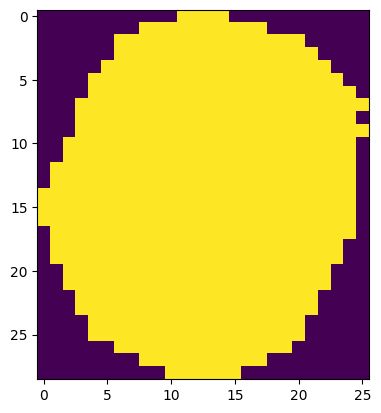

In [22]:
plt.imshow(c.mask)